In [1]:
import numpy as np
import pandas as pd
import glob
import pickle
import zipfile as zpf
import os
import re
from dateutil.parser import parse as dateparse
from dateutil.parser import ParserError
from tqdm import tqdm

In [2]:
soc_boards = glob.glob('../Data/usenet-soc/*')

In [3]:
sizes = [os.path.getsize(board) for board in soc_boards]
totsize = np.sum(sizes)
props = sizes / totsize

In [4]:
np.random.choice(soc_boards, 10, p=props)

array(['../Data/usenet-soc/soc.culture.japan.mbox.zip',
       '../Data/usenet-soc/soc.culture.singapore.mbox.zip',
       '../Data/usenet-soc/soc.culture.iraq.mbox.zip',
       '../Data/usenet-soc/soc.culture.asturies.mbox.zip',
       '../Data/usenet-soc/soc.culture.caribbean.mbox.zip',
       '../Data/usenet-soc/soc.support.fat-acceptance.mbox.zip',
       '../Data/usenet-soc/soc.culture.german.mbox.zip',
       '../Data/usenet-soc/soc.culture.taiwan.mbox.zip',
       '../Data/usenet-soc/soc.history.war.world-war-ii.mbox.zip',
       '../Data/usenet-soc/soc.college.admissions.mbox.zip'], dtype='<U70')

In [5]:
with zpf.ZipFile('../Data/usenet-talk/talk.meow.mbox.zip', 'r') as zp:
    raw = zp.open('talk.meow.mbox')

def usenet_reader(zp: zpf.ZipExtFile):
    outfile = b''
    line = True
    spot = zp.tell()
    while line:
        line = zp.readline()
        if re.match(b'From [\d-]+$', line):
            if outfile != b'':
                yield str(outfile), zp.tell() - spot
                spot = zp.tell()
            outfile = b''
            
        outfile += line

In [6]:
failures = []
class Post():
    def __init__(self, data):
        global failures
        raw = str(data.encode('latin1').decode('unicode_escape'))

        try:
            try:
                s = re.findall('(?<=[fF]rom: )\S+@[\w.]+', raw)[0]
            except IndexError:
                try:
                    s = re.findall('(?<=[fF]rom: )[\w \'<>,".\-@!+\\\\]+', raw )[0]
                    s = re.findall('(?<=<)[\S]+@[\S]+(?=>)', s)[0]
                except IndexError:
                    s = ''
            self.source = s

            d = re.findall('(?<=[Dd]ate: )[\w ,.:]+', raw)[0]
            try:
                self.date = dateparse(d)
            except ParserError:
                self.date = d

            ngroups = re.findall('(?<=[Nn]ewsgroups: )[\w ,.]+', raw )[0].split(',')

            self.newsgroups = ngroups

            s = re.findall('(?<=[Ss]ubject: )[[\]\S .,:-]+', raw)[0]
            self.subject = s

            try:
                mid = re.findall('(?<=[mM]essage-[iI][dD]: )[\S]+(?=\\n)', raw)[0]
                self.message_id = mid
            except IndexError as e:
                failures.append(e.__traceback__)
                self.message_id = f'no_mid_{len(failures)}'

            lines = [(len(x) > 0 and ':' not in x) for x in raw.split('\n')[1:]]
            self.body = '\n'.join(raw.split('\n')[np.argmax(lines)+1:])
        except IndexError as e:
            self.message_id = f'no_mid_{len(failures)}'
            failures.append(e.__traceback__)
    
    def __repr__(self):
        return f'Post ID: {self.message_id}'
    
    def __str__(self):
        return f'Post from: {self.source} with subject: {self.subject}'

    def __eq__(self, other):
        return self.message_id == other.message_id
    
    def __hash__(self):
        return hash(self.message_id)

class Newsgroup(set):
    def __init__(self, name, posts=[], loc='auto'):
        super().__init__(self)
        hierarchy = name.split('.')[0]
        if loc == 'auto':
            if not os.path.exists(f'../Data/{hierarchy}'):
                loc = '.'
            else:
                loc = f'../Data/{hierarchy}'

        self.file_name = loc + '/' + name + '.zip'
        self.name = name
        self.load()
        for post in posts:
            self.add(post)
    
    def save(self):
        with zpf.ZipFile(self.file_name, 'w') as f:
            with f.open(f'{self.name}.pkl', 'w') as jar:
                pickle.dump(self, jar)

    def load(self):
        try:
            with zpf.ZipFile(self.file_name, 'r') as f:
                with f.open(f'{self.name}.pkl', 'r') as jar:
                    oldset = pickle.load(jar)
                    for post in oldset:
                        self.add(post)
        except FileNotFoundError:
            pass
    
    @classmethod
    def from_mbox(cls, file_name, rm=False, save=True):
        name = file_name.split('/')[-1][:-9]
        hierarchy = name.split('.')[0]
        if not os.path.exists(f'../Data/{hierarchy}'):
            os.mkdir(f'../Data/{hierarchy}')
        self = cls(name, loc=f'../Data/{hierarchy}')
        with zpf.ZipFile(file_name, 'r') as zp:
            raw = zp.open(f'{name}.mbox')
            raw.seek(0, 2)
            size = raw.tell()
            raw.seek(0,0)

        post_iterator = usenet_reader(raw)
        with tqdm(usenet_reader(raw), total=size) as pbar:
            pbar.set_description(f'Loading {name}... ')
            for post, line in usenet_reader(raw):
                self.add(Post(post))
                pbar.update(line)
        if save:
            self.save()

        if rm:
            os.remove(file_name)
        
        return self
    
    @classmethod
    def from_hierarchy(cls, hierarchy):
        toplevel = hierarchy.split('.')[0]
        big_group = cls(hierarchy)
        all_boards = glob.glob(f'../Data/usenet-{toplevel}/{hierarchy}*')
        for group in all_boards:
            big_group |= Newsgroup.from_mbox(group, save=False)
        return big_group

In [7]:
aviation = Newsgroup.from_hierarchy('rec.aviation')

Loading rec.aviation.ifr... : 100%|█████████▉| 329173738/329174987 [01:17<00:00, 4265658.74it/s]


In [11]:
foo = []
for p in aviation:
    try:
        if 'foo fighter' in p.body.lower():
            foo.append(p)
    except AttributeError:
        pass

In [75]:
x = [1,2,3,4]
y = [1,2,3]
dist = 0


IndexError: list index out of range

In [43]:
dates = [p.date.date() for p in foo]

In [44]:
print(max(dates))
print(min(dates))

2011-12-20
1998-05-09


In [80]:
dataset = []
for p in foo:
    for ngroup in p.newsgroups:
        dataset.append((p.date, ngroup))
data = np.array(dataset)
data = pd.DataFrame(data, columns=['Date', 'Location'])
data.sort_values('Location')

,Date,Location
143,2007-11-29 17:41:25,alt.alien.research
234,2007-11-29 20:07:46,alt.alien.research
106,2007-11-29 13:00:48,alt.alien.research
102,2008-06-06 05:20:21,alt.alien.vampire.flonk.flonk.flonk
54,2008-06-06 04:42:52,alt.alien.vampire.flonk.flonk.flonk
...,...,...
238,2007-11-29 20:07:46,sci.physics
110,2007-11-29 13:00:48,sci.physics
147,2007-11-29 17:41:25,sci.physics
114,2007-07-01 23:41:15,sci.space.history


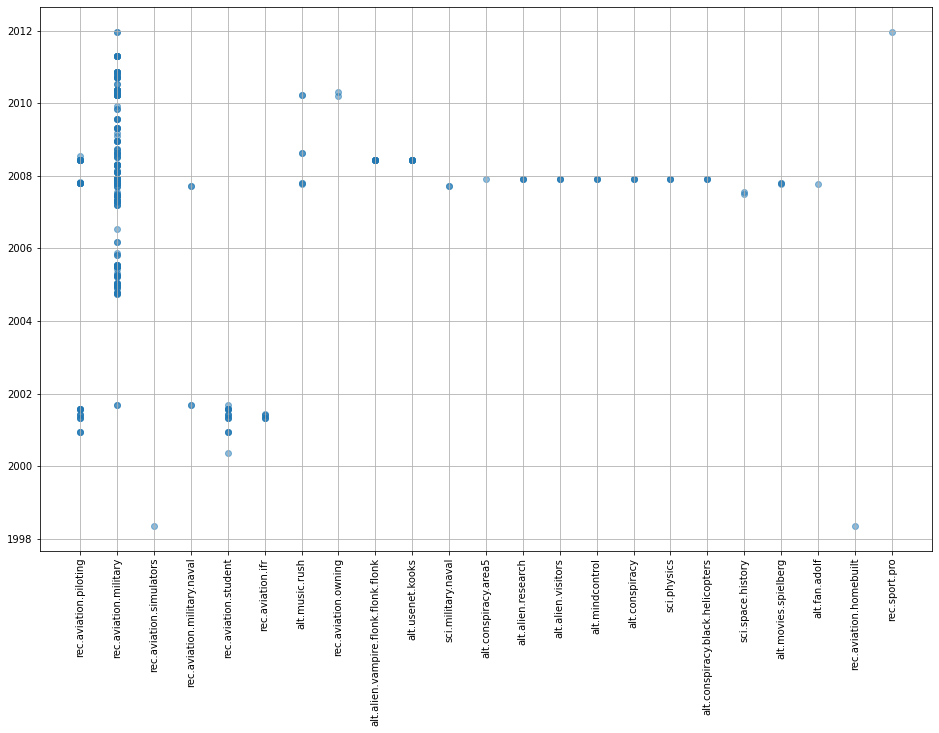

<Figure size 432x288 with 0 Axes>

In [83]:
plt.figure(figsize=(16, 10))
plt.scatter(data.Location, data.Date, alpha=.5)
plt.xticks(rotation=90)
plt.grid()
plt.show()
plt.savefig('Foo_Fighters.png')